In [220]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
HTDIR = "/storage/mgymrek/gtex/tfbs/encodedata/"
BEDDIR = "/storage/mgymrek/gtex/annotations/encode/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500 # For TSS

# Output path
OUTPATH = "pdfs"
PREFIX = "Figure2" # Keep as a variable in case we move things around!

# LIst of features to intersect with
"""
FEATURES = {
    "B_introns": os.path.join(ANNOTDIR, "introns.bed"),
    "C_3utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "D_5utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "E_promoter_1kb": os.path.join(ANNOTDIR, "hg19_promoter_1kb.bed"),
    "F_H3K4me1": os.path.join(HTDIR, "H3K4me1_GM12878.bed.gz"),
    "G_H3K4me2": os.path.join(HTDIR, "H3K4me2_GM12878.bed.gz"),
    "H_H3K4me3": os.path.join(HTDIR, "H3K4me3_GM12878.bed.gz"),
    "I_H3K27ac": os.path.join(HTDIR, "H3K27ac_GM12878.bed.gz"),
    "J_H3K27me3": os.path.join(HTDIR, "H3K27me3_GM12878.bed.gz"),
    "K_H3K36me3": os.path.join(HTDIR, "H3K36me3_GM12878.bed.gz"),  
}
"""
letters = ["A","B","C","D","E","F","G","H","I","J","K","L","M"]
i = 0
FEATURES = {}
for state in ["Active_Promoter","Weak_Promoter","Strong_Enhancer","Weak_Enhancer","Txn_Elongation","Txn_Transition","Weak_Txn","Heterochrom","Repressed"]:
    FEATURES[letters[i]+"_"+state] = os.path.join(BEDDIR,"%s_GM12878.bed"%state)
    i+= 1
#    "A_coding": os.path.join(ANNOTDIR, "coding.bed"),


Populating the interactive namespace from numpy and matplotlib


In [221]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
TISSUES=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/list_tissues

for t in $(cat $TISSUES)
do
    cat ${BASEDIR}/${t}/Lin_Reg_Out | grep -v gene | awk '{print $3 "\t" $5 "\t" $5+1}'
done | sort | uniq > all_analyzed_strs.bed

In [222]:
# Get features on all STRs analyzed - TODO update when we have all loci
all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","start","end"])
all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)
for key in FEATURES.keys():
    bedfile = FEATURES[key]
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%bedfile
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end"])
    feature_loci = set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
    all_strs[key] = np.where(all_strs["locus"].isin(feature_loci), 1, 0)

In [223]:
# Get data on best STR per gene
data = pd.read_csv(mergefile, sep='\t')
data['str.start']=data['best.str.start']
GG   = pd.read_csv(REGRSSION, sep='\t')
data_best = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues']], on=['chrom', 'str.start','gene' ] )

In [224]:
# TODO change these dfinitions
SCORE_THRESHOLD = 0.1 # causality score threshold
MINQ = 0.1 # FDR threshold for eSTR

data_best["is.estr"] = (data_best["best.q"]<=MINQ)
data_best["is.causal"] = data_best.apply(lambda x: "SNP" not in x["top.variant"] and x["best.score"]>=SCORE_THRESHOLD, 1)
data_best["is.causal.estr"] = (data_best["is.estr"] & data_best["is.causal"])

# Add features
data_best["start"] = data_best["best.str.start"]
data_best = pd.merge(data_best, all_strs)

In [225]:
OR_estr_vs_all = []
P_estr_vs_all = []

OR_causal_vs_all = []
P_causal_vs_all = []

OR_causal_vs_estr = []
P_causal_vs_estr = []

OR_causalestr_vs_all = []
P_causalestr_vs_all = []

keys = list(FEATURES.keys())

num_total_strs = all_strs.shape[0]
num_total_e_strs = sum(data_best["is.estr"])
num_total_causal = sum(data_best["is.causal"])
num_total_causal_e = sum(data_best["is.causal.estr"])

def NormTable(table, total):
    table[1][1] = total-sum(table)
    return table

for key in keys:
    num_total_feature = sum(all_strs[key])
    num_e_feature = sum(data_best[data_best["is.estr"]][key])
    num_causal_feature = sum(data_best[data_best["is.causal"]][key])
    num_causal_e_feature = sum(data_best[data_best["is.causal.estr"]][key])
        
    # eSTRs vs. non eSTRs 
    # [estr_feature, estr_nofeature]
    # [noestr_feature, none]
    table1 = [[num_e_feature, num_total_e_strs-num_e_feature],
            [num_total_feature-num_e_feature, 0]]
    table1 = NormTable(table1, num_total_strs)
    OR, p = ss.fisher_exact(table1)
    OR_estr_vs_all.append(OR)
    P_estr_vs_all.append(p)
    
    # causal vs. all
    table2 = [[num_causal_feature, num_total_causal-num_causal_feature],
            [num_total_feature-num_causal_feature, 0]]
    table2 = NormTable(table2, num_total_strs)
    OR, p = ss.fisher_exact(table2)
    OR_causal_vs_all.append(OR)
    P_causal_vs_all.append(p)
    
    # causal vs. eSTRs 
    # [causal_feature, causal_nofeature]
    # [nocausal_feature, none]
    table3 = [[num_causal_e_feature, num_total_causal_e - num_causal_e_feature],
            [num_e_feature-num_causal_e_feature, 0]]
    table3 = NormTable(table3, num_total_e_strs)
    OR, p = ss.fisher_exact(table3)
    OR_causal_vs_estr.append(OR)
    P_causal_vs_estr.append(p)
    
    # causalestr vs. all
    # [causalestr_feature, causalestr_nofeature]
    # [nocausalestr_feature, none]
    table4 = [[num_causal_e_feature, num_total_causal_e - num_causal_e_feature],
            [num_total_feature-num_causal_e_feature, 0]]
    table4 = NormTable(table4, num_total_strs)
    OR, p = ss.fisher_exact(table4)
    OR_causalestr_vs_all.append(OR)
    P_causalestr_vs_all.append(p)
        
enrich_table = pd.DataFrame({
    "feature": keys,
    "OR_estr_all": OR_estr_vs_all,
    "P_estr_all": P_estr_vs_all,
    "OR_causal_all": OR_causal_vs_all,
    "P_causal_all": P_causal_vs_all,
    "OR_causal_estr": OR_causal_vs_estr,
    "P_causal_estr": P_causal_vs_estr,
    "OR_causalestr_all": OR_causalestr_vs_all,
    "P_causalestr_all": P_causalestr_vs_all
})
enrich_table = enrich_table[["feature", "OR_estr_all","P_estr_all","OR_causal_all","P_causal_all","OR_causal_estr","P_causal_estr",
                            "OR_causalestr_all","P_causalestr_all"]]

enrich_table.sort_values("feature")

,feature,OR_estr_all,P_estr_all,OR_causal_all,P_causal_all,OR_causal_estr,P_causal_estr,OR_causalestr_all,P_causalestr_all
6,A_Active_Promoter,3.024851,2.441133e-10,3.265331,2.425870e-04,1.513651,0.219710,3.395590,1.659414e-04
0,B_Weak_Promoter,3.290923,3.156316e-11,5.018424,6.802421e-08,2.212037,0.007853,4.898563,1.991584e-07
4,C_Strong_Enhancer,1.246738,1.001724e-01,1.040118,8.742197e-01,0.785823,0.632172,0.978314,1.000000e+00
2,D_Weak_Enhancer,1.896692,5.691022e-12,2.590291,7.568575e-08,1.587965,0.014438,2.500185,3.659576e-07
3,E_Txn_Elongation,2.187818,6.654851e-24,1.555699,1.025327e-02,0.836898,0.359311,1.621500,4.920351e-03
8,F_Txn_Transition,2.049061,6.175438e-04,1.969945,9.968184e-02,1.165614,0.659602,2.047449,9.233303e-02
1,G_Weak_Txn,2.191519,6.435073e-51,1.795204,2.422056e-07,0.929697,0.562770,1.798436,3.076970e-07
5,H_Heterochrom,0.356799,5.919247e-138,0.394942,4.346950e-25,0.936173,0.524087,0.394579,2.272855e-24
7,I_Repressed,1.283382,1.294772e-02,1.066951,7.271333e-01,0.831477,0.558795,1.053474,8.122322e-01


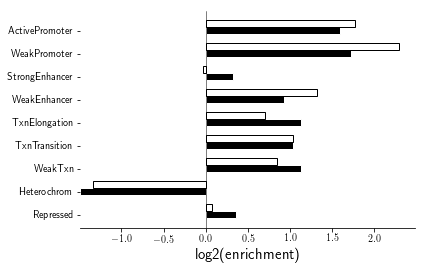

In [226]:
# Plot (OR_estr_all, OR_causal_all)
enrich_table = enrich_table.sort_values("feature", ascending=False)

w = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
yvals = np.array(range(len(keys)))
bars1 = ax.barh(yvals, np.log2(enrich_table["OR_estr_all"]), height=w, color="black", edgecolor="white")
bars2 = ax.barh(yvals+w, np.log2(enrich_table["OR_causalestr_all"]), height=w, color="white", edgecolor="black")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks(yvals)
ax.set_yticklabels([item[2:].replace("_","") for item in enrich_table["feature"]]);
ax.set_xlabel("log2(enrichment)", size=15);
fig.savefig(os.path.join(OUTPATH, "%s_causality_enrichment.pdf"))